In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks


# Read in cleaned data

In [114]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [115]:
df = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

- No need for padding/masking here, as the sequences are of equal length 

# Group Dataframe by date and LOR

In [116]:
# Group dataframe by date and LOR
df_theft_model = df.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft_model.fillna(value = 0, inplace=True)

In [119]:
# create "total" column which sums up data for each day
df_theft_model["total"] = df_theft_model.sum(axis=1)

df_theft_model.shape

(424, 13)

In [120]:
df_theft_model.head()

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12,total
date_theft_start,,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


In [121]:
pd.date_range(start = df["date_theft_start"].min(), end = df["date_theft_start"].max()).difference(df_theft_model.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

# Build a baseline model predicting total of stolen bikes

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


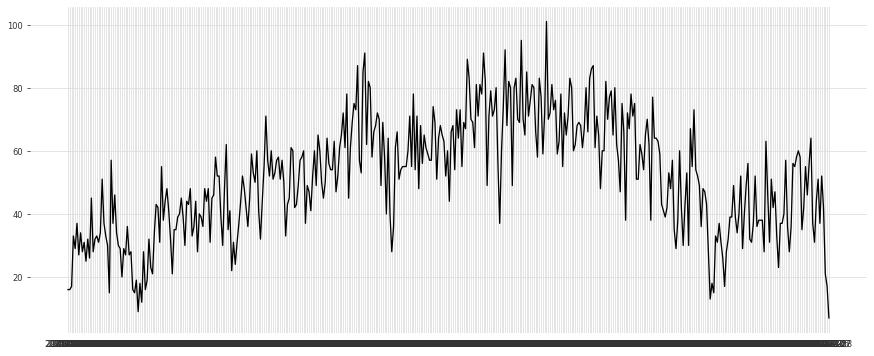

In [122]:
plt.figure(figsize=(15, 6))
plt.plot(df_theft_model["total"]);

## Create Train and Test Dataset

In [124]:
len(df_theft_model)

424

In [125]:
len_ = int(len(df_theft_model)*0.8)
len_

339

In [126]:
df_train = df_theft_model["total"][:len_]

In [127]:
df_test = df_theft_model["total"][len_:]

In [145]:
df_test.shape

(85,)

## Create Training and Test Arrays

In [128]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset[i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [188]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_train)
X_test, y_test = get_X_y(window_size, future_horizon, df_test)

In [189]:
X_train.shape

(307, 31)

In [190]:
X_test.shape

(53, 31)

In [191]:
X_test = np.expand_dims(X_test, 2)
X_train = np.expand_dims(X_train, 2)

In [192]:
X_train.shape

(307, 31, 1)

In [193]:
X_test.shape

(53, 31, 1)

## Baseline model

As a baseline model we just predict the mean of the train set. 

In [232]:
y_pred_base = [X_train.mean()] * len(y_test)

In [233]:
len(y_pred_base)

53

In [234]:
y_test.shape

(53, 1)

In [235]:
y_pred_base[0]

55.680046233056636

In [236]:
mean_squared_error(df_test, y_pred_base, squared = False)

ValueError: Found input variables with inconsistent numbers of samples: [85, 53]

In [237]:
mean_absolute_percentage_error(y_test, y_pred_base)

0.4421247216309894

## KFold Cross-Validation

In [225]:
from sklearn.model_selection import KFold

def model_cross_validation(model):
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):

        # split the data into train and test set
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model = model 
        
        # Fit the model
        model.fit(X_train_cv, y_train_cv, batch_size = 16, epochs = 300, verbose = 0)
        
        # Evaluate the model on the test data
        results.append(model.evaluate(X_test_cv, y_test_cv))
        
    return results

## Simple RNN model

In [167]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [226]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units = 10, activation = "tanh", input_shape = X_train.shape[1:]))
rnn_model.add(Dense(1, activation = "linear"))

rnn_model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")

In [227]:
rnn_model_cv_results = model_cross_validation(rnn_model)

2/2 [==============================] - 0s 4ms/step - loss: 138.6030 - mean_absolute_percentage_error: 16.2228


In [246]:
np.mean(rnn_model_cv_results, axis=0)

array([141.9028595 ,  20.80914249])

## Simple LSTM Model

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=10, activation='tanh', input_shape = X_train.shape[1:]))
lstm_model.add(Dense(1, activation="linear"))

lstm_model.compile(loss = "mse", 
                 optimizer = "adam", 
                 metrics = "mean_absolute_percentage_error")

In [ ]:
lstm_model_cv_results = model_cross_validation(lstm_model)

2/2 [==============================] - 0s 6ms/step - loss: 169.5703 - root_mean_squared_error: 13.0219


In [ ]:
lstm_model_cv_results

In [ ]:
np.mean(lstm_model_cv_results, axis=0)

## GRU Model

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(units=10, activation='tanh', input_shape = X_train.shape[1:]))
gru_model.add(Dense(1, activation="linear"))
gru_model.compile(loss = "mse", 
                 optimizer = "adam", 
                 metrics = RootMeanSquaredError())

In [ ]:
gru_model_cv_results = model_cross_validation(gru_model)

In [ ]:
gru_model_cv_results 

# Fit selected model

In [215]:
rnn_model_cv_results

In [218]:
history = rnn_model.fit(X_train, 
             y_train,
             batch_size = 16, 
             epochs=400, 
             validation_split=0.2,
             callbacks=[es],
             verbose = 1)

In [219]:
history.history

{'loss': [3578.006103515625,
  3557.828369140625,
  3537.951904296875,
  3518.141357421875,
  3498.4140625,
  3478.814697265625,
  3459.22216796875,
  3439.643798828125,
  3420.443603515625,
  3401.154052734375,
  3381.88232421875,
  3362.756103515625,
  3343.724853515625,
  3324.6396484375,
  3305.892578125,
  3287.08203125,
  3268.3740234375,
  3249.662353515625,
  3231.103271484375,
  3212.42431640625,
  3194.109130859375,
  3175.646728515625,
  3157.14892578125,
  3136.507568359375,
  3090.16455078125,
  3053.010986328125,
  3035.75341796875,
  3018.4453125,
  3000.884033203125,
  2983.485595703125,
  2966.342529296875,
  2949.11865234375,
  2929.32373046875,
  2894.180908203125,
  2875.72802734375,
  2859.19091796875,
  2842.418701171875,
  2825.9765625,
  2809.37109375,
  2792.96435546875,
  2776.4833984375,
  2760.283203125,
  2743.941650390625,
  2727.850830078125,
  2711.925537109375,
  2695.88330078125,
  2679.859375,
  2664.09130859375,
  2648.09912109375,
  2632.41577148437

In [169]:
mean_squared_error(y_test, rnn_model.predict(X_test), squared = False)

10.758578103591264

In [56]:
y_pred = rnn_model(X_test)

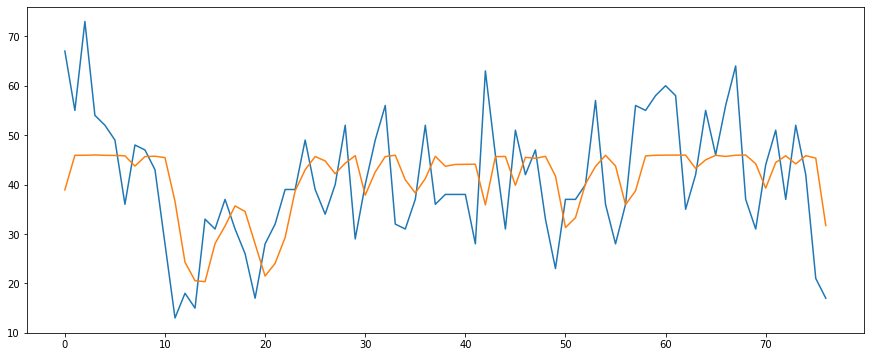

In [60]:
plt.figure(figsize=(15, 6))
plt.plot(y_test)
plt.plot(y_pred)

In [ ]:
11.623870687608381

## Simple LSTM model

In [40]:
mean_squared_error(y_test, lstm_model.predict(X_test), squared = False)

11.662904317901123

## Second (more complex) RNN model

In [47]:
rnn_model_2 = Sequential()
# first LSTM layer
rnn_model_2.add(LSTM(units = 20, activation = "tanh", return_sequences = True))
#rnn_model_2.add(Dropout(0.2))
# second LSTM layer
# rnn_model_2.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
rnn_model_2.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
#rnn_model_2.add(Dropout(0.2))

# output layer to predict one value
rnn_model_2.add(Dense(1, activation= "linear"))

rnn_model_2.compile(optimizer= "adam", loss= "mse", metrics = RootMeanSquaredError())

history = rnn_model_2.fit(X_train, 
                        y_train,
          batch_size=8, 
          epochs=300,
          validation_split=0.2,
          callbacks=[es], verbose = 1)

Epoch 1/300
33/33 [==============================] - 3s 28ms/step - loss: 3025.6809 - root_mean_squared_error: 55.0062 - val_loss: 4062.6362 - val_root_mean_squared_error: 63.7388
Epoch 2/300
33/33 [==============================] - 0s 5ms/step - loss: 2913.5740 - root_mean_squared_error: 53.9775 - val_loss: 3902.1865 - val_root_mean_squared_error: 62.4675
Epoch 3/300
33/33 [==============================] - 0s 6ms/step - loss: 2783.0842 - root_mean_squared_error: 52.7549 - val_loss: 3753.7979 - val_root_mean_squared_error: 61.2682
Epoch 4/300
33/33 [==============================] - 0s 5ms/step - loss: 2681.7178 - root_mean_squared_error: 51.7853 - val_loss: 3653.1035 - val_root_mean_squared_error: 60.4409
Epoch 5/300
33/33 [==============================] - 0s 5ms/step - loss: 2613.8020 - root_mean_squared_error: 51.1254 - val_loss: 3580.3037 - val_root_mean_squared_error: 59.8356
Epoch 6/300
33/33 [==============================] - 0s 5ms/step - loss: 2561.7454 - root_mean_squared_e

Epoch 92/300
33/33 [==============================] - 0s 5ms/step - loss: 745.0327 - root_mean_squared_error: 27.2953 - val_loss: 1130.6196 - val_root_mean_squared_error: 33.6247
Epoch 93/300
33/33 [==============================] - 0s 5ms/step - loss: 734.7825 - root_mean_squared_error: 27.1069 - val_loss: 1114.5200 - val_root_mean_squared_error: 33.3844
Epoch 94/300
33/33 [==============================] - 0s 5ms/step - loss: 724.6380 - root_mean_squared_error: 26.9191 - val_loss: 1098.7994 - val_root_mean_squared_error: 33.1481
Epoch 95/300
33/33 [==============================] - 0s 5ms/step - loss: 714.7237 - root_mean_squared_error: 26.7343 - val_loss: 1083.2502 - val_root_mean_squared_error: 32.9128
Epoch 96/300
33/33 [==============================] - 0s 5ms/step - loss: 704.8903 - root_mean_squared_error: 26.5498 - val_loss: 1068.2570 - val_root_mean_squared_error: 32.6842
Epoch 97/300
33/33 [==============================] - 0s 5ms/step - loss: 695.3660 - root_mean_squared_er

Epoch 138/300
33/33 [==============================] - 0s 5ms/step - loss: 432.7436 - root_mean_squared_error: 20.8025 - val_loss: 592.6555 - val_root_mean_squared_error: 24.3445
Epoch 139/300
33/33 [==============================] - 0s 5ms/step - loss: 428.9249 - root_mean_squared_error: 20.7105 - val_loss: 585.3265 - val_root_mean_squared_error: 24.1935
Epoch 140/300
33/33 [==============================] - 0s 5ms/step - loss: 425.4618 - root_mean_squared_error: 20.6267 - val_loss: 576.9622 - val_root_mean_squared_error: 24.0200
Epoch 141/300
33/33 [==============================] - 0s 5ms/step - loss: 421.6375 - root_mean_squared_error: 20.5338 - val_loss: 569.8096 - val_root_mean_squared_error: 23.8707
Epoch 142/300
33/33 [==============================] - 0s 5ms/step - loss: 406.5883 - root_mean_squared_error: 20.1640 - val_loss: 564.1920 - val_root_mean_squared_error: 23.7527
Epoch 143/300
33/33 [==============================] - 0s 5ms/step - loss: 398.7446 - root_mean_squared_e

Epoch 184/300
33/33 [==============================] - 0s 5ms/step - loss: 217.0768 - root_mean_squared_error: 14.7335 - val_loss: 282.2113 - val_root_mean_squared_error: 16.7991
Epoch 185/300
33/33 [==============================] - 0s 5ms/step - loss: 212.8738 - root_mean_squared_error: 14.5902 - val_loss: 277.3229 - val_root_mean_squared_error: 16.6530
Epoch 186/300
33/33 [==============================] - 0s 5ms/step - loss: 209.8314 - root_mean_squared_error: 14.4856 - val_loss: 273.3396 - val_root_mean_squared_error: 16.5330
Epoch 187/300
33/33 [==============================] - 0s 5ms/step - loss: 207.8821 - root_mean_squared_error: 14.4181 - val_loss: 269.2683 - val_root_mean_squared_error: 16.4094
Epoch 188/300
33/33 [==============================] - 0s 5ms/step - loss: 203.8273 - root_mean_squared_error: 14.2768 - val_loss: 266.2232 - val_root_mean_squared_error: 16.3163
Epoch 189/300
33/33 [==============================] - 0s 5ms/step - loss: 202.0359 - root_mean_squared_e

Epoch 230/300
33/33 [==============================] - 0s 5ms/step - loss: 138.5916 - root_mean_squared_error: 11.7725 - val_loss: 161.5397 - val_root_mean_squared_error: 12.7098
Epoch 231/300
33/33 [==============================] - 0s 5ms/step - loss: 137.1660 - root_mean_squared_error: 11.7118 - val_loss: 159.4019 - val_root_mean_squared_error: 12.6254
Epoch 232/300
33/33 [==============================] - 0s 5ms/step - loss: 136.8724 - root_mean_squared_error: 11.6992 - val_loss: 159.8694 - val_root_mean_squared_error: 12.6439
Epoch 233/300
33/33 [==============================] - 0s 5ms/step - loss: 138.6349 - root_mean_squared_error: 11.7743 - val_loss: 158.5690 - val_root_mean_squared_error: 12.5924
Epoch 234/300
33/33 [==============================] - 0s 5ms/step - loss: 137.0865 - root_mean_squared_error: 11.7084 - val_loss: 158.6007 - val_root_mean_squared_error: 12.5937
Epoch 235/300
33/33 [==============================] - 0s 5ms/step - loss: 131.0111 - root_mean_squared_e

Epoch 276/300
33/33 [==============================] - 0s 5ms/step - loss: 115.5940 - root_mean_squared_error: 10.7515 - val_loss: 145.1785 - val_root_mean_squared_error: 12.0490
Epoch 277/300
33/33 [==============================] - 0s 5ms/step - loss: 110.1779 - root_mean_squared_error: 10.4966 - val_loss: 135.3779 - val_root_mean_squared_error: 11.6352
Epoch 278/300
33/33 [==============================] - 0s 5ms/step - loss: 109.9932 - root_mean_squared_error: 10.4878 - val_loss: 133.9727 - val_root_mean_squared_error: 11.5747
Epoch 279/300
33/33 [==============================] - 0s 5ms/step - loss: 110.2181 - root_mean_squared_error: 10.4985 - val_loss: 139.6182 - val_root_mean_squared_error: 11.8160
Epoch 280/300
33/33 [==============================] - 0s 5ms/step - loss: 110.4857 - root_mean_squared_error: 10.5112 - val_loss: 134.0904 - val_root_mean_squared_error: 11.5797
Epoch 281/300
33/33 [==============================] - 0s 5ms/step - loss: 111.4266 - root_mean_squared_e

In [48]:
mean_squared_error(y_test, rnn_model_2.predict(X_test), squared = False)

11.716411403351922

## GRU model

In [125]:
gru_model = Sequential()
gru_model.add(GRU(units=10, activation='tanh', input_shape = X_train.shape[1:]))
gru_model.add(Dense(1, activation="linear"))
gru_model.compile(loss = "mse", 
                 optimizer = "adam", 
                 metrics = RootMeanSquaredError())

es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = gru_model.fit(X_train, 
                        y_train,
          batch_size=16, 
          epochs=300,
          validation_split=0.2,
          callbacks=[es], verbose = 0)

In [126]:
mean_squared_error(y_test, gru_model.predict(X_test), squared = False)

11.648536777248058

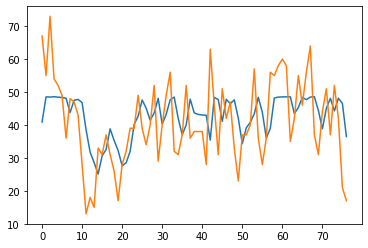

In [139]:
plt.plot(gru_model.predict(X_test))
plt.plot(y_test)

In [62]:
df_theft_model["total"].dtypes

dtype('float64')

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [64]:
df_darts = df_theft_model["total"].reset_index()

In [66]:
df_darts["date_theft_start"] = pd.to_datetime(df_darts["date_theft_start"])

In [72]:
len(df_darts)

424

In [73]:
darts_ts = TimeSeries.from_dataframe(df_darts, time_col="date_theft_start", value_cols="total")

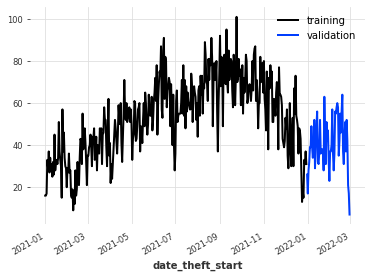

In [76]:
train, val = darts_ts.split_before(pd.Timestamp("20211231"))
train.plot(label="training")
val.plot(label="validation")

/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


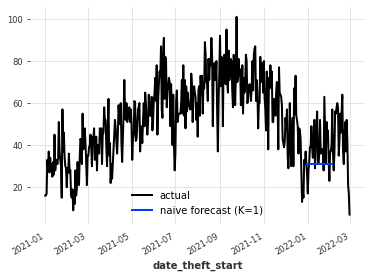

In [79]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

darts_ts.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

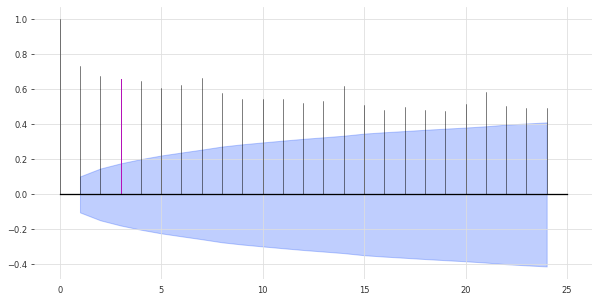

In [83]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=3, alpha=0.05)

In [84]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 17.
There is seasonality of order 21.


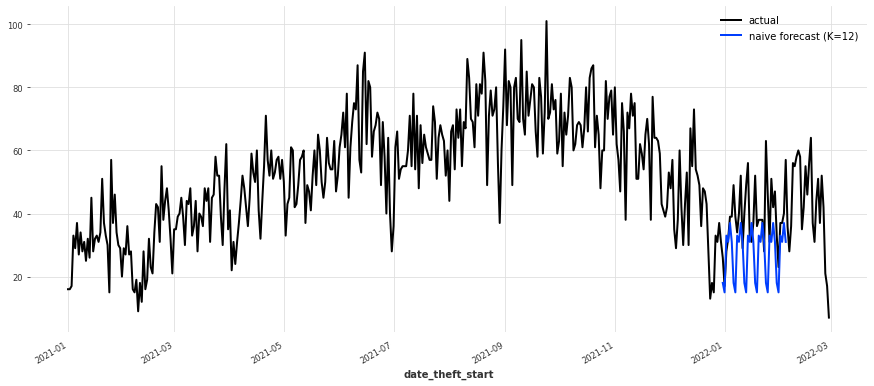

In [89]:
seasonal_model = NaiveSeasonal(K=6)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

plt.figure(figsize=(15, 6))
darts_ts.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

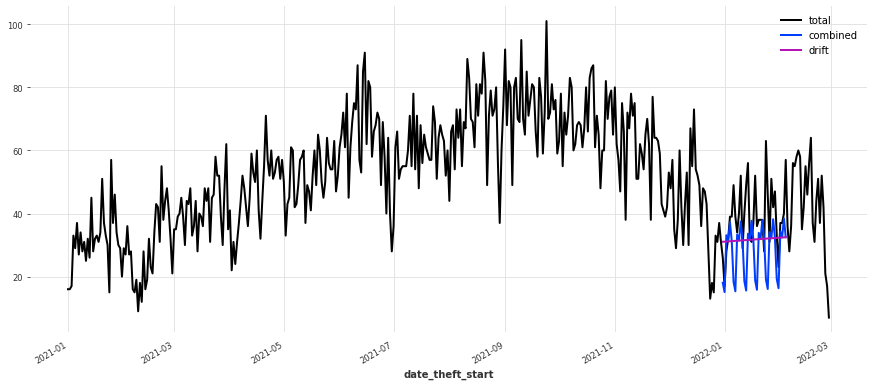

In [91]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

plt.figure(figsize=(15, 6))

darts_ts.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [92]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(darts_ts, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 27.49%.


In [103]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta, ARIMA, VARIMA, FourTheta, FFT, KalmanForecaster, \
                        RegressionModel, RandomForest, RNNModel, NBEATSModel, BlockRNNModel, TransformerModel, TFTModel


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ARIMA())
#eval_model(VARIMA())
eval_model(AutoARIMA())
eval_model(Theta())
eval_model(FourTheta())
eval_model(Prophet())
eval_model(FFT())
eval_model(KalmanForecaster())
eval_model(RegressionModel(lags=1))
eval_model(RandomForest(lags=1))
eval_model(RNNModel(input_chunk_length=90))
eval_model(NBEATSModel(input_chunk_length=90, output_chunk_length=7))


model ARIMA(12, 1, 0) obtains MAPE: 33.64%


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model Auto-ARIMA obtains MAPE: 31.91%
model Theta(2) obtains MAPE: 33.02%
model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 33.02%


/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


model Prophet obtains MAPE: 35.45%
model FFT(nr_freqs_to_keep=10, trend=None) obtains MAPE: 33.89%
model Kalman Filter Forecaster (dim_x=1) obtains MAPE: 33.83%
model LinearRegression(n_jobs=-1) obtains MAPE: 52.23%


/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/darts/timeseries.py:3283: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
/home/jakob/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/darts/timeseries.py:3283: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
[2022-03-02 15:49:45,581] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 340 samples.
[2022-03-02 15:49:45,581] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 340 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 340 sam

model RandomForest(lags={'target': [-1]}, n_estimators=100, max_depth=None) obtains MAPE: 59.47%
Epoch 99: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.22it/s, loss=1.17e+03]
Predicting: 11it [00:00, ?it/s]
model <darts.models.forecasting.rnn_model.RNNModel object at 0x7f102b19a580> obtains MAPE: 39.35%


[2022-03-02 15:49:59,457] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
[2022-03-02 15:49:59,457] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 268 samples.
[2022-03-02 15:49:59,514] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-02 15:49:59,514] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 6.7 M 
------------

Epoch 99: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.41it/s, loss=0.475]
Predicting: 9it [00:00, ?it/s]
model <darts.models.forecasting.nbeats.NBEATSModel object at 0x7f102b175580> obtains MAPE: 51.27%


TypeError: __init__() missing 2 required positional arguments: 'input_chunk_length' and 'output_chunk_length'

In [105]:
eval_model(BlockRNNModel(input_chunk_length=90, output_chunk_length=7))
eval_model(TransformerModel(input_chunk_length=90, output_chunk_length=7))



[2022-03-02 15:52:59,606] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
[2022-03-02 15:52:59,606] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 268 samples.
[2022-03-02 15:52:59,611] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-02 15:52:59,611] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | rnn       | RNN        | 700   
2 | fc      

Epoch 99: 100%|████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 66.10it/s, loss=1.74e+03]
Predicting: 9it [00:00, ?it/s]
model <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x7f102dbcf1f0> obtains MAPE: 47.33%


[2022-03-02 15:53:12,911] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
[2022-03-02 15:53:12,911] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 268 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 268 samples.
[2022-03-02 15:53:12,927] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-02 15:53:12,927] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             

Epoch 99: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.11it/s, loss=242]
Predicting: 9it [00:00, ?it/s]

[2022-03-02 15:55:22,439] ERROR | darts.models.forecasting.tft_model | ValueError: TFTModel requires future covariates. The model applies multi-head attention queries on future inputs. Consider specifying a future encoder with `add_encoders` or setting `add_relative_index` to `True` at model creation (read TFT model docs for more information). These will automatically generate `future_covariates` from indexes.
[2022-03-02 15:55:22,439] ERROR | darts.models.forecasting.tft_model | ValueError: TFTModel requires future covariates. The model applies multi-head attention queries on future inputs. Consider specifying a future encoder with `add_encoders` or setting `add_relative_index` to `True` at model creation (read TFT model docs for more information). These will automatically generate `future_covariates` from indexes.
ERROR:darts.models.forecasting.tft_model:ValueError: TFTModel requires future covariates. The model applies multi-head attention queries on future inputs. Consider specifyi


model <darts.models.forecasting.transformer_model.TransformerModel object at 0x7f102dbcfe20> obtains MAPE: 74.34%


ValueError: TFTModel requires future covariates. The model applies multi-head attention queries on future inputs. Consider specifying a future encoder with `add_encoders` or setting `add_relative_index` to `True` at model creation (read TFT model docs for more information). These will automatically generate `future_covariates` from indexes.

In [111]:
eval_model(RNNModel(model = "LSTM", input_chunk_length=90))


[2022-03-02 16:01:55,045] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 340 samples.
[2022-03-02 16:01:55,045] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 340 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 340 samples.
[2022-03-02 16:01:55,050] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-02 16:01:55,050] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | rnn       | LSTM    | 2.8 K 
2 | V         | Linear  

Epoch 99: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.58it/s, loss=992]
Predicting: 11it [00:00, ?it/s]
model <darts.models.forecasting.rnn_model.RNNModel object at 0x7f102b1b6520> obtains MAPE: 34.82%
